## LABS EEG pre-processing and spectral analysis pipeline

Created by Toomas Erik Anijärv in 20.04.2023

This notebook is a representation of EEG processing done for the LABS participants acquired from R-drive at 22.03.2023.

You are free to use this or any other code from [EEG-pyline](https://github.com/teanijarv/EEG-pyline) for your own projects and publications. Preferably, you could contact me (toomaserikanijarv@gmail.com / tanijarv@usc.edu.au) once you start using this data for your paper and I could help you write the EEG-related Methodology section of the manuscript. Additionally, if you use the cleaned EEG files or spectral analysis data for your research project, please include the following DOI as a citation - https://doi.org/10.5281/zenodo.7444821. Just add this to your reference manager (e.g., Zotero) and it should create you a similar citation as the example below:

*Anijärv, Toomas Erik. (2023). EEG-pyline: EEG pipeline in Python (v0.1.2). Zenodo. https://doi.org/10.5281/zenodo.7601253*

In [ ]:
import mne, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#mne.set_log_level('error')
import warnings

# Set the current working directory to be the project main folder
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.spectral_analysis as spectr

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`). In `raw_folder` and `clean_folder`, there is `timepoints` folder which contains `exp_conditions` folder.

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder/timepoints[i]/exp_conditions[j]` and later saved to `clean_folder/exp_folder/timepoints[i]/exp_conditions[j]`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'
results_folder = 'Results/'

exp_folder = 'LABS'
timepoints = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8',
              'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15']
exp_conditions = ['EC', 'EO']

### PRE-PROCESSING

(1) The raw EEG files from `raw_folder/exp_folder` (across all timepoints and two conditions) are read in, montage is set to `biosemi32`, signals are re-referenced to `average`, and cropped to `240s` to include only the "resting" part.

(2) `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with the `signal-space projections (SSP)` method.

(3) Artefact rejection is done with `Autoreject` package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

(4) The clean EEG signals are exported to `clean_folder/exp_folder`.

In [96]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
reference = 'average'
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

In [97]:
for timepoint in timepoints:
    print('Checking files in', timepoint)
    for exp in exp_conditions:
        # Set the directory in progress and find all BDF (raw EEG) files in there
        dir_inprogress = os.path.join(clean_folder, exp_folder, timepoint,exp)
        export_dir = os.path.join(clean_folder, exp_folder, timepoint, exp)
        file_dirs, subject_names = arrange.read_files(dir_inprogress, '.fif')

Checking files in T1
Files in Data/Clean/LABS/T1/EC read in: 94
Files in Data/Clean/LABS/T1/EO read in: 92
Checking files in T2
Files in Data/Clean/LABS/T2/EC read in: 86
Files in Data/Clean/LABS/T2/EO read in: 83
Checking files in T3
Files in Data/Clean/LABS/T3/EC read in: 71
Files in Data/Clean/LABS/T3/EO read in: 72
Checking files in T4
Files in Data/Clean/LABS/T4/EC read in: 74
Files in Data/Clean/LABS/T4/EO read in: 73
Checking files in T5
Files in Data/Clean/LABS/T5/EC read in: 61
Files in Data/Clean/LABS/T5/EO read in: 60
Checking files in T6
Files in Data/Clean/LABS/T6/EC read in: 42
Files in Data/Clean/LABS/T6/EO read in: 43
Checking files in T7
Files in Data/Clean/LABS/T7/EC read in: 59
Files in Data/Clean/LABS/T7/EO read in: 57
Checking files in T8
Files in Data/Clean/LABS/T8/EC read in: 44
Files in Data/Clean/LABS/T8/EO read in: 44
Checking files in T9
Files in Data/Clean/LABS/T9/EC read in: 31
Files in Data/Clean/LABS/T9/EO read in: 30
Checking files in T10
Files in Data/C

For illustrative purposes, the example output includes only one participant.

------
Working with files in T1 
Files in Data/Raw/LABS/T1/ read in: 1

 0 
---
Cleaning EEG for LAB_3522_01_EC
Extracting EDF parameters from /Users/tanijarv/Documents/GitHub/EEG-pyline/Data/Raw/LABS/T1/LAB_3522_01_EC.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274431  =      0.000 ...   267.999 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3 events found
Event IDs: [1 2 8]
Event markers are following:
[[ 22556      0      1]
 [ 22658      0      8]
 [268329      0      2]]
Starting point: 22.02734375 s
Ending point: 262.0400390625 s
Total duration: 240.0126953125 s
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
NOTE: plot_psd

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/Users/tanijarv/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


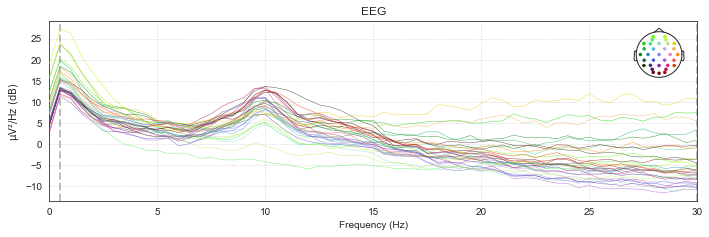

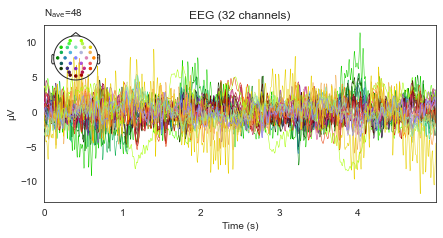

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


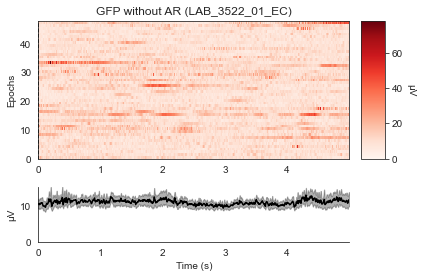

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00044798565440070385}
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=31


  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


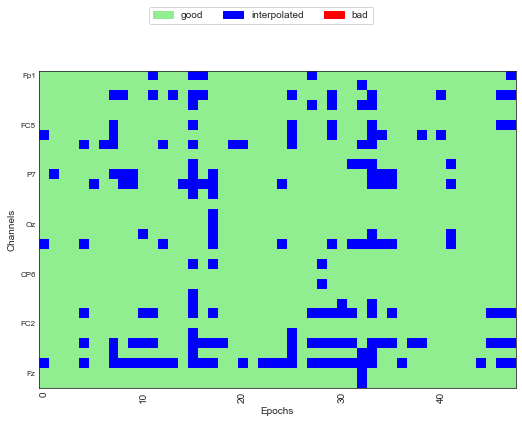

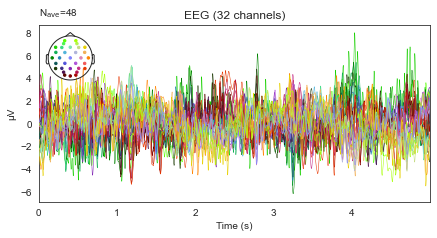

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


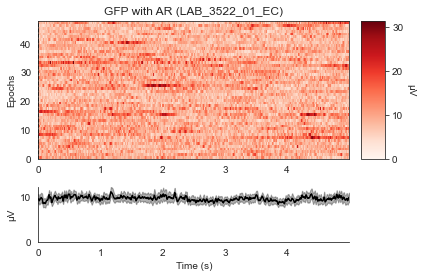

In [101]:
timepoint = 'T1'
plot_psd = True

for exp in exp_conditions:
    print('------\nWorking with files in', timepoint, exp)
    # Set the directory in progress and find all BDF (raw EEG) files in there
    dir_inprogress = os.path.join(raw_folder, exp_folder, timepoint,exp)
    export_dir = os.path.join(clean_folder, exp_folder, timepoint, exp)
    file_dirs, subject_names = arrange.read_files(dir_inprogress, '.bdf')

    for i, file in enumerate(file_dirs):
        print('\n',i,'\n---\nCleaning EEG for', subject_names[i])
        # Read in the raw EEG data
        raw = mne.io.read_raw_bdf(file, infer_types=True, eog=eog_channels,
                                  stim_channel=stimulus_channel)

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
                .set_eeg_reference(ref_channels=reference, verbose=False)

        # Find event markers for the start and end of resting state recordings
        events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
        
        # If there is 3 events, then crop the signal by the first and last event point
        if len(events) >= 3:
            tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]
            # If there is more than 3, warn the user (as probably requires manual processing)
            if len(events) > 3:
                warnings.warn('\nMore than 3 event points found for {}\n'.format(subject_names[i]))
        # If there is 1 or 2 event points, check whether they are start or end points or similar to each
        elif len(events) == 1 or len(events) == 2:
            warnings.warn('\nOnly 1 or 2 event point(s) found for {}\n'.format(subject_names[i]))

            if events[0][0] > 100000:
                tminmax = [0, events[0][0]/raw.info['sfreq']]
            else:
                tminmax = [events[0][0]/raw.info['sfreq'], None]
        else:
            tminmax = None
            warnings.warn('\nNO event points found for {}\n'.format(subject_names[i]))

        # Use the markers to crop to EEG signal to leave only the actual resting state
        if tminmax != None:
            cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
            print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
            'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
            # Warn if signal length is not what it is expected for a single condition
            if (230 <= tminmax[1]-tminmax[0] <= 250) != True:
                warnings.warn('\nRaw signal length is not between 230-250s for {}\n'.format(subject_names[i]))
        else:
            cropped_raw = raw
            print('Signal NOT cropped.')
        cropped_raw = cropped_raw.drop_channels(stimulus_channel)
        
        # Filter the signal with bandpass filter and remove EOG artefacts with SSP
        filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                        eog_channels=eog_channels, plot_filt=False, savefig=False, verbose=False)
        
        if plot_psd == True: mne.viz.plot_raw_psd(filt, fmin=0, fmax=30)

        # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
        %matplotlib inline
        epochs = pre_process.artefact_rejection(filt, subject_names[i], epo_duration=epochs_duration, verbose=False)

        # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
        #%matplotlib qt
        #epochs.plot(n_channels=32,n_epochs=1)

        # Try to create a directory and save the EEG file to that directory
        try:
            os.makedirs(export_dir)
        except FileExistsError:
            pass
        try:
            mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
        except FileExistsError:
            pass

### POWER SPECTRAS AND BANDPOWERS

Estimation of `Welch's power spectrum density (PSD)` is done for all the participants at all timepoints, both conditions, for all 32 channls and six brain regions (i.e., `Left frontal`, `Right frontal`, `Left temporal`, `Right temporal`, `Left posterior`, `Right posterior`). The PSD estimates are divided into five frequency bands - `delta (1-3.9 Hz)`, `theta (4-7.9 Hz)`, `alpha (8-12 Hz)`, `beta (12.1-30 Hz)`.

Welch's PSD is calculated for `1-30 Hz` frequency range using `2.5-second Hamming window (50% overlap)` and 3 times the window (7.5-second) zero-padding.

The results are saved as Excel spreadsheets (channel-by channel and regionally) to `results_folder/exp_folder`.

In [ ]:
### DEFINE ###
b_names = ['Delta', 'Theta', 'Alpha', 'Beta']
b_freqs = [[1, 3.9], [4, 7.9], [8, 12], [12.1, 30]]
brain_regions = {'Left frontal' : ['AF3', 'F3', 'FC1'],
                 'Right frontal' : ['AF4', 'F4', 'FC2'],
                 'Left temporal' : ['F7', 'FC5', 'T7'],
                 'Right temporal' : ['F8', 'FC6', 'T8'],
                 'Left posterior' : ['CP5', 'P3', 'P7'],
                 'Right posterior' : ['CP6', 'P4', 'P8']}

psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=3)

# Pre-create results folders for spectral analysis data
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_folder)

sns.set_palette('muted')
sns.set_style("whitegrid")

For illustrative purposes, the example output includes only three participants.

Files in Data/Clean/LABS/T1/EC read in: 94
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 44 epochs × 32 channels × 291 freqs, 1.0-30.0 Hz>
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 7680

Samples per segment: 2560
Samples for FFT: 10240
Frequency resolution: 0.10000000000000009 Hz


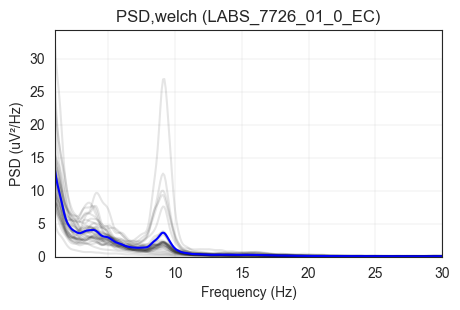

Finding bandpower within [1, 3.9] Hz with Ln normalisation set to False
Finding bandpower within [4, 7.9] Hz with Ln normalisation set to False
Finding bandpower within [8, 12] Hz with Ln normalisation set to False
Finding bandpower within [12.1, 30] Hz with Ln normalisation set to False
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 48 epochs × 32 channels × 291 freqs, 1.0-30.0 Hz>
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 7680

Samples per segment: 2560
Samples for FFT: 10240
Frequency resolution: 0.10000000000000009 Hz


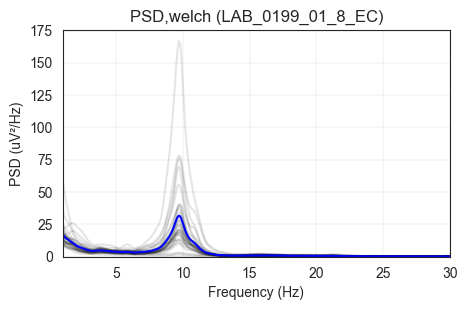

Finding bandpower within [1, 3.9] Hz with Ln normalisation set to False
Finding bandpower within [4, 7.9] Hz with Ln normalisation set to False
Finding bandpower within [8, 12] Hz with Ln normalisation set to False
Finding bandpower within [12.1, 30] Hz with Ln normalisation set to False
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 48 epochs × 32 channels × 291 freqs, 1.0-30.0 Hz>
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 7680

Samples per segment: 2560
Samples for FFT: 10240
Frequency resolution: 0.10000000000000009 Hz


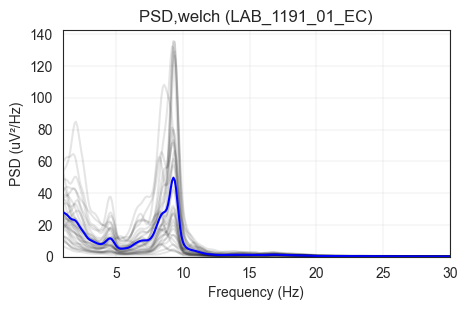

Finding bandpower within [1, 3.9] Hz with Ln normalisation set to False
Finding bandpower within [4, 7.9] Hz with Ln normalisation set to False
Finding bandpower within [8, 12] Hz with Ln normalisation set to False
Finding bandpower within [12.1, 30] Hz with Ln normalisation set to False


,Condition,Timepoint,Band,Fp1,AF3,F7,F3,FC1,FC5,T7,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
Subject,,,,,,,,,,,,,,,,,,,,,
LABS_7726_01_0_EC,EC,T1,Delta,5.279389,1.696853,7.942879,3.669868,6.254288,5.841993,8.337273,...,3.733759,7.686589,5.875017,5.422575,5.500498,10.214770,3.430654,8.477205,4.261643,7.500778
LABS_7726_01_0_EC,EC,T1,Theta,1.476111,0.419516,1.819652,1.501833,3.259328,2.053762,2.515410,...,1.622295,3.117093,2.029631,2.634409,1.936041,2.962500,0.853119,2.061086,1.975763,3.507011
LABS_7726_01_0_EC,EC,T1,Alpha,1.017096,0.133419,0.412714,0.465547,1.169787,0.755076,1.121401,...,0.961620,1.307713,1.016303,1.115892,0.863409,1.061836,0.259899,1.100776,0.580355,1.445986
LABS_7726_01_0_EC,EC,T1,Beta,0.104235,0.036872,0.118442,0.078203,0.140337,0.120247,0.274281,...,0.097185,0.231382,0.150473,0.126673,0.152529,0.209410,0.078293,0.142691,0.083277,0.117335
LAB_0199_01_8_EC,EC,T1,Delta,14.157859,3.656614,8.463145,6.070441,10.503789,6.013944,8.673842,...,6.622024,7.969558,7.941517,7.640337,8.790934,10.570703,6.616986,18.913353,8.984282,8.217542
LAB_0199_01_8_EC,EC,T1,Theta,4.253132,1.049481,2.587047,2.557714,4.616989,2.659328,4.454226,...,3.058430,4.241074,3.008079,3.963145,3.452773,3.712620,1.943880,4.309989,4.372513,5.090440
LAB_0199_01_8_EC,EC,T1,Alpha,14.637676,0.707996,2.146778,4.579494,10.977193,5.964115,8.170316,...,11.188399,9.488215,8.029907,11.979561,6.924165,6.230172,1.461940,8.745442,7.075765,14.936137
LAB_0199_01_8_EC,EC,T1,Beta,0.675346,0.224593,0.422894,0.591251,0.887032,0.428965,0.930207,...,0.434104,0.609528,0.492777,0.707636,0.799445,0.576036,0.372319,0.731864,0.705666,0.478296
LAB_1191_01_EC,EC,T1,Delta,17.261085,8.769069,14.319051,6.395618,3.298245,7.247387,18.167949,...,10.653260,29.889238,12.122412,4.996436,9.770729,16.862000,15.302825,22.838801,4.951868,7.456447


,Condition,Timepoint,Band,Left frontal,Right frontal,Left temporal,Right temporal,Left posterior,Right posterior
Subject,,,,,,,,,
LABS_7726_01_0_EC,EC,T1,Delta,3.873669,4.784576,7.374048,7.925459,4.374994,6.593888
LABS_7726_01_0_EC,EC,T1,Theta,1.726892,1.807857,2.129608,2.703075,1.898195,2.841889
LABS_7726_01_0_EC,EC,T1,Alpha,0.589584,0.746400,0.763064,1.128617,1.167896,1.931447
LABS_7726_01_0_EC,EC,T1,Beta,0.085137,0.119165,0.170990,0.197088,0.136379,0.188828
LAB_0199_01_8_EC,EC,T1,Delta,6.743615,7.682753,7.716977,8.827259,6.070079,10.208357
LAB_0199_01_8_EC,EC,T1,Theta,2.741394,3.119933,3.233534,3.653924,3.621744,5.307180
LAB_0199_01_8_EC,EC,T1,Alpha,5.421561,6.788555,5.427070,7.916098,15.004119,30.638623
LAB_0199_01_8_EC,EC,T1,Beta,0.567625,0.626467,0.594022,0.559447,0.493346,0.760368
LAB_1191_01_EC,EC,T1,Delta,6.154311,10.023330,13.244796,19.624550,23.831777,22.538065


In [95]:
df_psd_ch_bands = pd.DataFrame()
# Go through all timepoints (i.e., T1, T2, etc) AND conditions (i.e., EC, EO)
for t in range(len(timepoints)):
    for c in range(len(exp_conditions)):
        # Set the directory in progress and find all FIF (clean EEG) files in there
        dir_inprogress = os.path.join(clean_folder, exp_folder, timepoints[t], exp_conditions[c])
        file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')

        for i in range(len(file_dirs)):
            # Read in the clean EEG data
            epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                        verbose=False)
            
            # Calculate Welch's power spectrum density
            [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], **psd_params,
                                                verbose=True, plot=True)
            
            for j in range(len(b_names)):
                # Devide the PSD to frequency band bins and calculate absolute bandpowers incl. signal quality check
                psd_ch_band_temp = spectr.bandpower_per_channel(psds, freqs, b_freqs[j], b_names[j],
                                                        subject_names[i], epochs)
                # Convert the array to dataframe and add the corresponding band, timepoint and condition
                df_psd_ch_band_temp = arrange.array_to_df(subject_names[i], epochs, psd_ch_band_temp)
                df_psd_ch_band_temp.insert(0, 'Condition', exp_conditions[c]) # FIX!
                df_psd_ch_band_temp.insert(1, 'Timepoint', timepoints[t]) # FIX!
                df_psd_ch_band_temp.insert(2, 'Band', b_names[j])

                # Concatenate it to the dataframe including all the previous subjects
                df_psd_ch_bands = pd.concat([df_psd_ch_bands, df_psd_ch_band_temp])
            
# Average the channels together for the specified regions
df_psd_reg_bands = arrange.df_channels_to_regions(df_psd_ch_bands.reset_index(), brain_regions)
df_psd_reg_bands = df_psd_reg_bands.set_index(df_psd_ch_bands.index)
df_psd_reg_bands.insert(0, 'Condition', df_psd_ch_bands['Condition'])
df_psd_reg_bands.insert(1, 'Timepoint', df_psd_ch_bands['Timepoint'])
df_psd_reg_bands.insert(2, 'Band', df_psd_ch_bands['Band'])

# Display and export the final results
display(df_psd_ch_bands)
display(df_psd_reg_bands)
df_psd_ch_bands.to_excel('{}/{}/{}_channels_bandpowers.xlsx'.format(results_folder, exp_folder, exp_folder))
df_psd_reg_bands.to_excel('{}/{}/{}_regions_bandpowers.xlsx'.format(results_folder, exp_folder, exp_folder))

### ALPHA REACTIVITY

`Alpha reactivity` is calculated with the following formula:
$$Alpha reactivity = (EC alpha power - EO alpha power) / EC alpha power$$

The results are saved as Excel spreadsheets (channel-by channel and regionally) to `results_folder/exp_folder`.

In [5]:
df_psd_ch_bands = pd.read_excel('{}/{}/{}_channels_bandpowers.xlsx'.format(results_folder, exp_folder, exp_folder))
df_psd_reg_bands = pd.read_excel('{}/{}/{}_regions_bandpowers.xlsx'.format(results_folder, exp_folder, exp_folder))

In [87]:
def alpha_reactivity(df_psd_bands):
    # Choose only alpha band from the bandpowers dataframe
    df_psd_alpha = df_psd_bands[df_psd_bands['Band']=='Alpha']
    # Divide the alpha dataframe to EC and EO conditions
    df_psd_alpha_EC = df_psd_alpha[df_psd_alpha['Condition']=='EC'].reset_index(drop=True)
    df_psd_alpha_EC['Subject'] = df_psd_alpha_EC['Subject'].str.removesuffix('_EC')
    df_psd_alpha_EO = df_psd_alpha[df_psd_alpha['Condition']=='EO'].reset_index(drop=True)
    df_psd_alpha_EO['Subject'] = df_psd_alpha_EO['Subject'].str.removesuffix('_EO')
    # Merge the two conditions together to one dataframe by only including subjects who have both conditions
    df_psd_alpha_EC_EO = df_psd_alpha_EC.merge(df_psd_alpha_EO, on='Subject', how='inner', suffixes=('_EC', '_EO'))
    # Create new dataframe and calculate alpha reactivity for each subject
    df_psd_alpha_reactivity = pd.DataFrame(columns=df_psd_bands.columns).drop(columns=['Condition', 'Band'])
    df_psd_alpha_reactivity['Subject'] = df_psd_alpha_EC_EO['Subject']
    df_psd_alpha_reactivity['Timepoint'] = df_psd_alpha_EC_EO['Timepoint_EC']
    for ch in df_psd_alpha_reactivity.columns[2:]:
        df_psd_alpha_reactivity['{}'.format(ch)] = (df_psd_alpha_EC_EO['{}_EC'.format(ch)] - df_psd_alpha_EC_EO['{}_EO'.format(ch)]) / df_psd_alpha_EC_EO['{}_EC'.format(ch)]
    
    return df_psd_alpha_reactivity

In [93]:
df_psd_ch_alpha_reactivity = alpha_reactivity(df_psd_ch_bands).set_index(['Subject'])
df_psd_reg_alpha_reactivity = alpha_reactivity(df_psd_reg_bands).set_index(['Subject'])

display(df_psd_ch_alpha_reactivity)
display(df_psd_reg_alpha_reactivity)

df_psd_ch_alpha_reactivity.to_excel('{}/{}/{}_channels_alpha_reactivity.xlsx'.format(results_folder, exp_folder, exp_folder))
df_psd_reg_alpha_reactivity.to_excel('{}/{}/{}_regions_alpha_reactivity.xlsx'.format(results_folder, exp_folder, exp_folder))

,Timepoint,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,C4,T8,FC6,FC2,F4,F8,AF4,Fp2,Fz,Cz
Subject,,,,,,,,,,,,,,,,,,,,,
LABS_7726_01_0,T1,0.608686,-0.291504,-0.063868,0.078257,0.410180,0.230651,0.255399,0.555464,0.590991,...,0.522661,0.374520,0.482559,0.453677,0.394655,0.323328,0.055289,0.281826,0.261869,0.569218
LAB_0199_01_8,T1,0.606811,-0.020461,0.181847,0.366076,0.526756,0.376055,0.407632,0.364627,0.480860,...,0.409799,0.433730,0.480000,0.549352,0.481362,0.491164,0.277474,0.701594,0.480740,0.593953
LAB_1191_01,T1,0.134532,0.918760,0.839693,0.217635,-3.222218,0.088007,-0.035709,-0.818118,0.692471,...,-0.376050,0.354547,0.148730,-1.233654,0.057349,0.724290,0.770617,0.085170,-0.675581,0.194212
LAB_1211_01_2,T1,0.526439,0.039350,-0.034279,0.320313,0.535686,0.443673,0.368769,0.152210,0.409544,...,0.399187,0.226971,-0.045442,0.267430,-0.043038,0.026645,-0.043552,0.724567,0.115073,0.680573
LAB_1218_01,T1,0.805686,0.702562,0.770860,-0.180343,0.234366,0.167033,0.282527,0.508840,0.841310,...,0.660110,0.386681,0.233092,0.362350,0.022953,0.398874,0.355790,0.759119,-0.366539,0.674887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAB_1986_15,T15,0.748984,0.959649,0.772608,0.776701,0.707894,0.611348,0.532783,0.085250,-1.572538,...,0.499895,-0.630071,0.330802,0.703946,0.744467,0.692366,0.956101,0.790682,0.799860,0.652895
LAB_2776_15,T15,0.837372,0.013239,0.080303,0.571929,0.718840,0.571940,0.649908,0.472632,0.620551,...,0.277461,0.564871,0.474134,0.661432,0.638767,0.703006,0.508441,0.740408,0.649801,0.748435
LAB_4972_15,T15,0.794195,0.956234,0.672289,0.759117,0.451534,0.429547,-0.181982,0.045925,-3.731202,...,0.340590,-0.451020,0.157482,0.572165,0.658464,0.363864,0.927644,0.800925,0.785423,-0.274776


,Timepoint,Left frontal,Right frontal,Left temporal,Right temporal,Left posterior,Right posterior
Subject,,,,,,,
LABS_7726_01_0,T1,0.269887,0.384679,0.189676,0.390895,0.515969,0.589183
LAB_0199_01_8,T1,0.457695,0.506719,0.366293,0.464442,0.615140,0.735496
LAB_1191_01,T1,0.202135,0.118594,0.332930,0.409970,0.535010,0.457174
LAB_1211_01_2,T1,0.385496,0.147813,0.296650,0.091235,0.424463,0.515439
LAB_1218_01,T1,0.287494,0.278644,0.411082,0.340473,0.678287,0.752064
...,...,...,...,...,...,...,...
LAB_1986_15,T15,0.821104,0.801921,0.648615,0.257656,0.632329,0.706075
LAB_2776_15,T15,0.654891,0.646890,0.566890,0.554616,0.668883,0.805168
LAB_4972_15,T15,0.739140,0.731310,0.372873,0.089837,0.520362,0.691156
